# Project

In [1]:
import os
import string
import pickle
import re
import sys
import math
import cPickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from operator import itemgetter
from time import time
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest, chi2
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

In [2]:
%matplotlib inline

In [3]:
# %load poi_id.py
# %%writefile poi_id.py # run this when finished.
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# TODO: when finished code from below blocks 

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def format_float(x):
    return int(x*1000.0)/1000.0

def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    cols = df.columns.values.tolist()[1:]
    df[cols] = df[cols].applymap(format_float)
    df_formatted = pd.concat([df_fmt, df])
    print(df_formatted.to_csv(sep="|", index=False, decimal='', float_format='%.3f'))

# Task 1

Lets first start with the full set and then decide whish parameters to continue with.

In [5]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi"] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
for k,v in data_dict['METTS MARK'].iteritems():
    if k not in ["poi","email_address"]:
        features_list.append(k)
print str(features_list)

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']


_____________________________
There is one value which is not actually a data point but a aggregation entry. It is total row in dataset.

In [6]:
completeness = pd.DataFrame(data_dict).replace('NaN', np.nan, regex=True).isnull().mean().sort_values(ascending=False)
completeness[:10]

LOCKHART EUGENE E                0.952381
GRAMM WENDY L                    0.857143
WROBEL BRUCE                     0.857143
WHALEY DAVID A                   0.857143
THE TRAVEL AGENCY IN THE PARK    0.857143
WAKEHAM JOHN                     0.809524
WODRASKA JOHN                    0.809524
CLINE KENNETH W                  0.809524
GILLIS JOHN                      0.809524
SCRIMSHAW MATTHEW                0.809524
dtype: float64

In [7]:
data_dict['LOCKHART EUGENE E']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

In [8]:
### Task 2: Remove outliers
print data_dict['TOTAL']
print data_dict["LOCKHART EUGENE E"]
del data_dict['TOTAL']
del data_dict["LOCKHART EUGENE E"]

{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}
{'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'exercised_stock_options': 'NaN', 'bonus': 'NaN', 'restricted_stock': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 'N

## New Features

In [9]:
df = pd.DataFrame(data_dict).transpose()[features_list]
df = df.replace('NaN', np.nan, regex=True)
def is_NaN(x):
    return x == 'NaN'
df.head(3)

,poi,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,False,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,NaN,2195.0,152.0,65.0,NaN,-3081055.0,304805.0,47.0
BADUM JAMES P,False,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,False,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,56301.0,NaN,29.0,864523.0,0.0,NaN,-5104.0,NaN,39.0


In [10]:
df[features_list[1:]].describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,9.400000e+01,86.000000,3.800000e+01,1.240000e+02,1.010000e+02,8.100000e+01,1.090000e+02,86.000000,1.700000e+01,1.250000e+02,94.000000,3.000000e+00,86.000000,9.200000e+01,86.000000,16.000000,4.800000e+01,6.500000e+01,86.000000
mean,2.840875e+05,2073.860465,8.416025e+05,2.623421e+06,2.959559e+06,1.201773e+06,1.147424e+06,1176.465116,6.218928e+05,3.352073e+06,54192.010638,2.797500e+07,608.790698,4.652767e+05,41.232558,89822.875000,-5.810498e+05,7.464912e+05,64.895349
std,1.771311e+05,2582.700981,1.289323e+06,9.488106e+06,5.499450e+06,1.441679e+06,2.249770e+06,1178.317641,3.845528e+06,6.532883e+06,46108.377454,4.638256e+07,1841.033949,1.389719e+06,100.073111,41112.700735,9.420764e+05,8.629174e+05,86.979244
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,3.285000e+03,7.000000e+04,-2.604490e+06,2.000000,-1.787380e+06,-4.409300e+04,148.000000,4.000000e+05,12.000000,2.000000e+00,0.000000,3285.000000,-3.504386e+06,6.922300e+04,0.000000
25%,2.118020e+05,541.250000,7.964450e+04,3.863802e+05,5.067650e+05,4.250000e+05,2.520550e+05,249.750000,-3.298250e+05,4.941360e+05,22479.000000,1.200000e+06,22.750000,1.209000e+03,1.000000,83674.500000,-6.112092e+05,2.750000e+05,10.000000
50%,2.587410e+05,1211.000000,2.210635e+05,1.100246e+06,1.297049e+06,7.500000e+05,4.410960e+05,740.500000,-1.402640e+05,1.095040e+06,46547.500000,2.000000e+06,41.000000,5.198450e+04,8.000000,106164.500000,-1.519270e+05,4.221580e+05,35.000000
75%,3.086065e+05,2634.750000,8.672112e+05,2.084663e+06,2.542813e+06,1.200000e+06,9.850320e+05,1888.250000,-7.241900e+04,2.606763e+06,78408.500000,4.176250e+07,145.500000,3.575772e+05,24.750000,112815.000000,-3.792600e+04,8.318090e+05,72.250000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,3.434838e+07,8.000000e+06,1.476169e+07,5521.000000,1.545629e+07,4.911008e+07,228763.000000,8.152500e+07,14368.000000,1.035973e+07,609.000000,137864.000000,-8.330000e+02,5.145434e+06,528.000000


sns.heatmap(abs(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [11]:
# remove NaNs from train data:
def clean_train_data(features):
    for line in features:
        for i,v in enumerate(line):
            if np.isnan(v):
                line[i] = -1.0
    return features

In [12]:
def predict_na_values(df, column):
    print("Predicting missing values for {}.".format(column)) 
    columns = df.columns.values.tolist()
    columns.remove(column)
    # do not translate poi info into missing variables
    columns.remove("poi")
    ok = df[df[column].notnull()]
    ok_features = clean_train_data(ok[columns].values.tolist())
    ok_labels = ok[column].values.tolist()
    nok = df[df[column].isnull()]
    if len(nok)<1:
        print("No missing values for {}!".format(column))
        return
    clf_g = GaussianNB()
    clf_g.fit(ok_features,ok_labels)
    nok_features = clean_train_data(nok[columns].values.tolist())
    pred = clf_g.predict(nok_features)
    df.loc[nok.index,column] = pred

In [13]:
### Fill missing fields with predictions
for column in df.columns.values.tolist():
    ## Do not predict poi 
    if column != "poi":
        predict_na_values(df, column)

Predicting missing values for salary.
Predicting missing values for to_messages.
Predicting missing values for deferral_payments.
Predicting missing values for total_payments.
Predicting missing values for exercised_stock_options.
Predicting missing values for bonus.
Predicting missing values for restricted_stock.
Predicting missing values for shared_receipt_with_poi.
Predicting missing values for restricted_stock_deferred.
Predicting missing values for total_stock_value.
Predicting missing values for expenses.
Predicting missing values for loan_advances.
Predicting missing values for from_messages.
Predicting missing values for other.
Predicting missing values for from_this_person_to_poi.
Predicting missing values for director_fees.
Predicting missing values for deferred_income.
Predicting missing values for long_term_incentive.
Predicting missing values for from_poi_to_this_person.


In [14]:
corr = df.corr()

In [15]:
corr_limit = 0.35

In [16]:
def map_(x):
    if abs(x)==1:
        return 0
    elif abs(x)>corr_limit:
        return int(100.0*x)
    return 0

In [17]:
pd.DataFrame(corr.applymap(map_))

,poi,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
poi,0,0,0,0,0,40,0,0,0,0,38,0,0,0,0,0,0,0,0,0
salary,0,0,0,0,56,50,50,50,0,0,54,0,48,0,57,0,0,0,41,0
to_messages,0,0,0,0,0,0,36,36,70,0,0,0,0,41,0,50,0,0,0,48
deferral_payments,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,-43,0,40
total_payments,0,56,0,0,0,60,57,60,0,72,66,0,96,0,82,0,0,0,51,0
exercised_stock_options,40,50,0,0,60,0,46,59,0,0,96,0,59,0,55,0,0,0,55,0
bonus,0,50,36,0,57,46,0,41,62,0,49,0,45,0,39,41,0,0,47,61
restricted_stock,0,50,36,0,60,59,41,0,0,0,78,0,59,0,63,0,0,0,40,0
shared_receipt_with_poi,0,0,70,41,0,0,62,0,0,0,0,0,0,0,0,50,0,0,0,69
restricted_stock_deferred,0,0,0,0,72,0,0,0,0,0,0,0,67,0,44,0,0,0,0,0


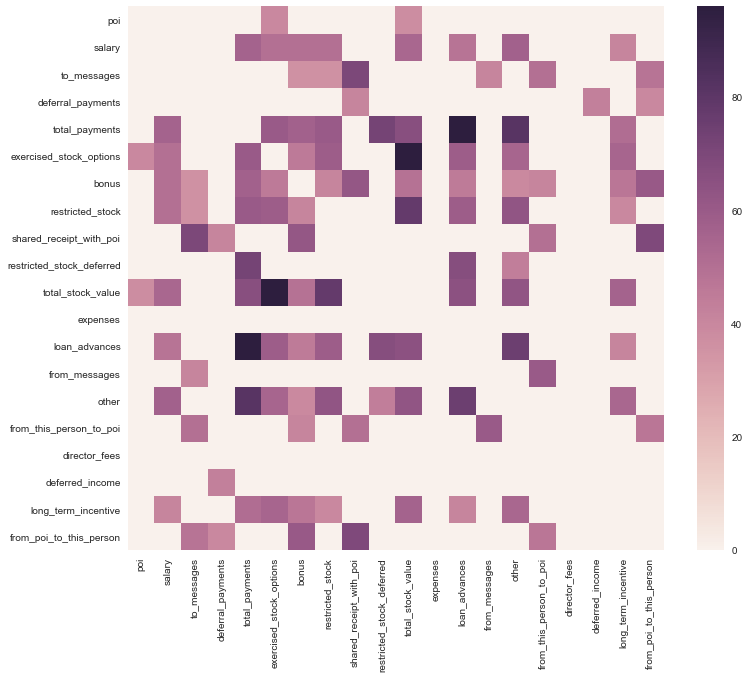

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(abs(corr.applymap(map_)), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [19]:
def extract_parameters_by_correlation(corr, min_corr, depth, selections):
    features = corr.columns.values.tolist()
    new_selections = []
    for sel in selections:
        for f in features:
            if (sel != f) and (f not in selections+new_selections) and (f in corr) and (abs(corr[sel][f]) > min_corr):
                new_selections.append(f)
    selections = selections+new_selections
    if depth < 1:
        return selections
    else:
        return extract_parameters_by_correlation(corr, min_corr, depth-1, selections)

In [20]:
primary_components = extract_parameters_by_correlation(corr, corr_limit, 2, ["poi"])
primary_components

['poi',
 'exercised_stock_options',
 'total_stock_value',
 'salary',
 'total_payments',
 'bonus',
 'restricted_stock',
 'loan_advances',
 'other',
 'long_term_incentive',
 'restricted_stock_deferred',
 'to_messages',
 'shared_receipt_with_poi',
 'from_this_person_to_poi',
 'from_poi_to_this_person']

In [21]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.

# Create new feaures
df['from_poi_ratio'] = df['from_poi_to_this_person']/df['to_messages']
df['to_poi_ratio'] = df['from_this_person_to_poi']/df['from_messages']

my_dataset = df.to_dict(orient='index')

In [73]:
selected_list = [
    'poi',
    'to_poi_ratio',
    'from_poi_to_this_person',
    'shared_receipt_with_poi',
    'restricted_stock_deferred',
    'expenses',
    'deferral_payments',
    'from_poi_ratio',
    'salary',
    'to_messages',
    'total_payments',
    'exercised_stock_options',
    'bonus']

In [74]:
#final_feature_list = primary_components
#final_feature_list = primary_components+['from_poi_ratio','to_poi_ratio']
#final_feature_list = features_list + ['from_poi_ratio', 'to_poi_ratio']
#final_feature_list = features_list
## parameters weigths extracted from full set
final_feature_list = selected_list

In [75]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, final_feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [76]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
clf_g = GaussianNB()

In [77]:
from sklearn.linear_model import LinearRegression
clf_ln = LinearRegression()

In [78]:
opts_l = {
    "alpha":[0.6,0.85,0.95,1.0],
    "fit_intercept":[True,False]
}
clf_l = GridSearchCV(Lasso(), opts_l)
#regression.fit(features, labels)
#pd.DataFrame(zip(features_list_,regression.coef_),columns=["name","coef"]).sort(['coef','name'], ascending=[0,1])

In [79]:
from sklearn import svm
opts_s = {
    "C":[0.1,1.0,10.0],
    #"kernel":["linear", "poly", "rbf"]
}
clf_s = GridSearchCV(svm.SVC(),opts_s)

In [80]:
opts_t = {
    "criterion":["gini","entropy"],
    "min_samples_leaf":[1,2,5],
    "min_samples_split":[2,4,10]
}
clf_t = GridSearchCV(DecisionTreeClassifier(random_state=42), opts_t)

In [81]:
opts_f = {
    "criterion":["gini","entropy"],
    "n_estimators":[5,10,30,100,200],
    "min_samples_leaf":[1,2,5],
    "min_samples_split":[2,4,10]
}
clf_f = GridSearchCV(RandomForestClassifier(random_state = 42), opts_f)
#print("Accuracy: {:.2f}% {}".format(model_predictor(clf)*100, (k+1)*5))

In [82]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


# Example starting point. Try investigating other evaluation techniques!
from sklearn.model_selection  import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [83]:
def test_different_combinations(feature_list,results):
    feature_list = feature_list[:-1]
    data = featureFormat(my_dataset, ["poi"]+feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2)
    clf.fit(features_train,labels_train)
    y_pred = clf.predict(features_test)
    accuracy, precision, recall, f1, f2 = get_scores(y_pred,labels_test)
    results.append([len(feature_list),accuracy, precision, recall, f1, f2])
    if len(feature_list)>3:
        test_different_combinations(feature_list,results)
    return results

In [84]:
def get_weights(feature_list):
    clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
        max_features=None, max_leaf_nodes=None,
        min_impurity_split=1e-07, min_samples_leaf=1,
        min_samples_split=2, min_weight_fraction_leaf=0.0,
        presort=False, random_state=42, splitter='best')
    clf.fit(features_train,labels_train)
    weights = zip(feature_list,clf.feature_importances_)
    weights_df = pd.DataFrame(sorted(weights, key=itemgetter(1), reverse=True), columns=["Parameter", "Weight"])
    return weights_df

In [85]:
weights = get_weights(final_feature_list[1:])
weights[weights["Weight"]>0]

,Parameter,Weight
0,to_poi_ratio,0.337183
1,from_poi_to_this_person,0.234436
2,restricted_stock_deferred,0.115503
3,shared_receipt_with_poi,0.099882
4,expenses,0.093253
5,deferral_payments,0.066904
6,from_poi_ratio,0.052840


In [86]:
f_list = weights["Parameter"].tolist()
res = test_different_combinations(f_list,[])
pd.DataFrame(res,columns=["# of features", "accuracy", "precision", "recall", "f1", "f2"])

,# of features,accuracy,precision,recall,f1,f2
0,11,0.909091,0.666666,0.4,0.500000,0.434782
1,10,0.909091,0.666666,0.4,0.500000,0.434782
2,9,0.909091,0.666666,0.4,0.500000,0.434782
3,8,0.909091,0.666666,0.4,0.500000,0.434782
4,7,0.909091,0.666666,0.4,0.500000,0.434782
5,6,0.886364,0.500000,0.2,0.285714,0.227273
6,5,0.886364,0.500000,0.4,0.444444,0.416666
7,4,0.840909,0.000000,0.0,0.000000,0.000000
8,3,0.818182,0.000000,0.0,0.000000,0.000000


In [87]:
ff_list = f_list[:12]
ff_list

['to_poi_ratio',
 'from_poi_to_this_person',
 'restricted_stock_deferred',
 'shared_receipt_with_poi',
 'expenses',
 'deferral_payments',
 'from_poi_ratio',
 'salary',
 'to_messages',
 'total_payments',
 'exercised_stock_options',
 'bonus']

In [88]:
pandas_df_to_markdown_table(get_weights(final_feature_list[1:]))

Parameter|Weight
---|---
to_poi_ratio|0.337
from_poi_to_this_person|0.234
restricted_stock_deferred|0.115
shared_receipt_with_poi|0.099
expenses|0.093
deferral_payments|0.066
from_poi_ratio|0.052
salary|0.0
to_messages|0.0
total_payments|0.0
exercised_stock_options|0.0
bonus|0.0



In [89]:
models = [
    {"name":"GaussianNB","predictor":clf_g},
    {"name":"Linear Regression","predictor":clf_ln},
    {"name":"Lasso","predictor":clf_l},
    {"name":"SVC","predictor":clf_s},
    {"name":"DecisionTreeClassifier","predictor":clf_t},
    {"name":"RandomForestClassifier","predictor":clf_f}
]

### Scores for Linear Models:

clf_g.fit(features_train, labels_train)
clf_ln.fit(features_train, labels_train)
print "GaussianNB score:  {}".format(clf_g.score(features_test, labels_test))
print "Linear Regression score:  {}".format(clf_ln.score(features_test, labels_test))

### Scores for Other Models w/ Grid Search:

In [90]:
def round_pred(x):
    if x>=0.5:
        return 1.0
    return 0.0

In [91]:
def get_scores(predictions,truth):
    true_negatives = 0
    false_negatives = 0
    false_positives = 0
    true_positives = 0
    for prediction, truth in zip(predictions, labels_test):
        p_int = round_pred(prediction)
        if p_int == 0 and truth == 0:
            true_negatives += 1
        elif p_int == 0 and truth == 1:
            false_negatives += 1
        elif p_int == 1 and truth == 0:
            false_positives += 1
        elif p_int == 1 and truth == 1:
            true_positives += 1
        else:
            print "Warning: Found a predicted label not == 0 or 1. value:{}".format(str(prediction))
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = 1.0*(true_positives + true_negatives)/total_predictions
    precision = 1.0*true_positives/(true_positives+false_positives+0.000001)
    recall = 1.0*true_positives/(true_positives+false_negatives+0.000001)
    f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives+0.000001)
    f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall+0.000001)
    return [accuracy, precision, recall, f1, f2]

In [92]:
def model_predictor(classifier):
    classifier.fit(features_train, labels_train)
    y_pred = classifier.predict(features_test)
    accuracy, precision, recall, f1, f2 = get_scores(y_pred,labels_test)
    return [accuracy, precision, recall, f1, f2]

In [93]:
def run_predictors():
    params = {}
    scores = []
    for predictor in models:
        accuracy, precision, recall, f1, f2 = model_predictor(predictor["predictor"])
        scores.append([predictor["name"], accuracy, precision, recall, f1, f2])
        # print("{} accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}, F1: {:.2f}, F2: {:.2f}".format(predictor["name"], accuracy, precision, recall, f1, f2))
        if hasattr(predictor["predictor"],"best_estimator_"):
            params[predictor["name"]] = predictor["predictor"].best_estimator_
        else:
            params[predictor["name"]] = predictor["predictor"]
        score_table = pd.DataFrame(scores, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1 Score", "F2 Score"])
    return params, score_table

In [94]:
params, score_table = run_predictors()
score_table

,Classifier,Accuracy,Precision,Recall,F1 Score,F2 Score
0,GaussianNB,0.886364,0.500000,0.6,0.545454,0.576923
1,Linear Regression,0.909091,0.666666,0.4,0.500000,0.434782
2,Lasso,0.909091,0.666666,0.4,0.500000,0.434782
3,SVC,0.886364,0.000000,0.0,0.000000,0.000000
4,DecisionTreeClassifier,0.909091,0.666666,0.4,0.500000,0.434782
5,RandomForestClassifier,0.886364,0.000000,0.0,0.000000,0.000000


In [95]:
pandas_df_to_markdown_table(score_table)

Classifier|Accuracy|Precision|Recall|F1 Score|F2 Score
---|---|---|---|---|---
GaussianNB|0.886|0.499|0.599|0.545|0.576
Linear Regression|0.909|0.666|0.399|0.499|0.434
Lasso|0.909|0.666|0.399|0.499|0.434
SVC|0.886|0.0|0.0|0.0|0.0
DecisionTreeClassifier|0.909|0.666|0.399|0.499|0.434
RandomForestClassifier|0.886|0.0|0.0|0.0|0.0



### Best Parameters:

In [42]:
clf = params["DecisionTreeClassifier"]
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [43]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, final_feature_list)

In [44]:
# %load tester.py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.86053	Precision: 0.47111	Recall: 0.37500	F1: 0.41759	F2: 0.39095
	Total predictions: 15000	True positives:  750	False positives:  842	False negatives: 1250	True negatives: 12158

